# Eye-tracker pupil detection model   
<hr></hr>
<b>Author:</b> Owen Burt  

<b>Date created:</b> 2/21/2025

<b>Last modified</b> 5/5/2025  

<hr></hr>

<b>Description:</b>  

In this notebook I prepare data and construct a model that predicts the location of a pupil. 

<b>References:</b>  
- Referenced <b>mathworks.com</b> to learn about r-cnn, fast r-cnn, and faster r-cnn.
- Referenced and used code from the AI text book 'Applied Machine Learning and AI for Engineers' used in the AI/ML course by <b>Jeff Prosise</b>.
- Referenced and used code from <b>Tensorflow</b> to help understand tensorflows framework, use their pre-trained models, and output images with matlibplot.
- Referneced paper on Faster Convolutional Neural Networks from Cornell Univeristy called 'Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks' by <b>Shaoqing Ren, et al</b>. I used this article to help me understand the Faster R-CNN.  
- Referenced 'Everything you need to know about VGG16' by <b>Rohini G</b> to help me build a model that closly replicates the VGG16 model commonly used for object classification.  
- Referenced 'Building an object detector in TensorFlow using bounding-box regression' by <b>Chatura Wijetunga</b> for a basic understanding of object detection with TensorFlow.  
- Referenced 'Convolutional Neural Networks In Depth' by <b>Rajesh Katta</b> to better understand CNN's.  
- Referenced ChatGPT, I take credit for the majority of the code in this notebook. however, I referenced ChatGPT often since working with a large library like TensorFlow can be confusing in terms of locating and understanding functions. 

<b>Sources:</b>  
- mathworks.com: https://www.mathworks.com/help/vision/ug/getting-started-with-r-cnn-fast-r-cnn-and-faster-r-cnn.html
- Tensorflow: https://www.tensorflow.org/tutorials/images/cnn
- Cornell Univeristy: https://arxiv.org/abs/1506.01497  
- VGG16 schema (Rohini G): https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918  
- Shaoqing Ren, et al: https://arxiv.org/abs/1506.01497  
- Chatura Wijetunga: https://medium.com/nerd-for-tech/building-an-object-detector-in-tensorflow-using-bounding-box-regression-2bc13992973f  
- Rajesh Katta: https://medium.com/@kattarajesh2001/convolutional-neural-networks-in-depth-c2fb81ebc2b2  



<hr></hr>
  


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import os as os
import cv2


<hr></hr>

## Data preprocessing
 
I'm starting with a folder containing all the images and their corresponding annotations as well as a CSV called ```eye_data.csv```, which contains the file name of the image and the boundries of the pupil. This CSV was created with ```xml_to_csv.py```. In order to train a model on this data I will need each image (features) to be a 3D array conatinaing pixel data and the boundries (target) to be an array that corresponds to the correct image in the 3D array of images. I will also split the data with ```sklearn.model_selection.train_test_split``` so that I can use some for training and some for testing and validation. 


<hr></hr>

In [2]:
cwd = os.getcwd()
df = pd.read_csv(cwd + "/eye_data.csv")


In [3]:
df.head()

,file_name,obj_class,x1,y1,x2,y2
0,WIN_20250205_16_00_55_Pro.jpg,pupil,257,163,276,195
1,WIN_20250205_16_00_56_Pro.jpg,pupil,279,128,308,156
2,WIN_20250205_16_00_57_Pro.jpg,pupil,313,138,346,170
3,WIN_20250205_16_00_58_Pro.jpg,pupil,278,141,305,172
4,WIN_20250205_16_00_59_Pro.jpg,pupil,263,150,286,181


Creating a function that allows me to view the image and bounding boxes to ensure no major mistakes are made during data processing.

In [4]:
def view_image(image, x1, y1, x2, y2):
    ''' 
    view_image displays the bounding box on the image.

    :param image: a numpy array representing the image.
    :param x1: x min coordinates.
    :param y1: y min coordinates.
    :param x2: x max coordinates.
    :param y2: y max coordinates.
    '''

    image = image.copy()
    color = (0, 255, 0)
    thickness = 2

    cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)
    cv2.imshow('Bounding Box', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

In [5]:
x1 = df['x1'][0]
y1 = df['y1'][0]
x2 = df['x2'][0]
y2 = df['y2'][0]
try:
    img_path = cwd + '\\data\\images\\train\\' + df['file_name'][0]
    img = cv2.imread(img_path)
    view_image(img, x1, y1, x2, y2)
except:
    img_path = cwd + '\\data\\images\\val\\' + df['file_name'][0]
    img = cv2.imread(img_path)
    view_image(img, x1, y1, x2, y2)



### Splitting data into training, testing, and validation groups.


My training data will be 75% of original dataset, testing will be 10%, and validation will be 15%. After creating a few models I realized that I didn't need any testing data and could have gotten away with training and validation splits leaving more images for training. 


In [6]:

from sklearn.model_selection import train_test_split

X = df['file_name']
y = df[['x1', 'y1', 'x2', 'y2']]

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1 - train_ratio)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_ratio/(test_ratio + validation_ratio)) 



Resetting indices

In [7]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)


Viewing Image

In [8]:
x1 = y_train['x1'][1]
y1 = y_train['y1'][1]
x2 = y_train['x2'][1]
y2 = y_train['y2'][1]

try:
    img_path = cwd + '\\data\\images\\train\\' + X_train[1]
    img = cv2.imread(img_path)
    view_image(img, x1, y1, x2, y2)
except:
    img_path = cwd + '\\data\\images\\val\\' + X_train[1]
    img = cv2.imread(img_path)
    view_image(img, x1, y1, x2, y2)


In [9]:
X_val.head()

0    WIN_20250220_19_58_28_Pro.jpg
1    WIN_20250208_18_41_16_Pro.jpg
2    WIN_20250205_16_21_50_Pro.jpg
3    WIN_20250205_16_21_22_Pro.jpg
4    WIN_20250205_16_22_24_Pro.jpg
Name: file_name, dtype: object

In [10]:
y_val.head()

,x1,y1,x2,y2
0,0,0,0,0
1,283,135,313,165
2,273,147,298,179
3,273,142,296,172
4,312,142,349,176


### Converting images and boundry data to arrays and normalizing 

Currently, <b>X_data</b> is a <u>series</u> of file names and <b>y_data</b> is a <u>dataframe</u> containing boundry data. I want the training data to be an <u>array</u> of pixel data and the target data to be an <u>array</u> containing just the boundries with no labels/index. I will create a function that handles both of these tasks. Along with converting data to array format these funcitons will also handle normalizing the data. For the images I do this by dividing the pixel data by 255 since a pixel is comprised of three values ranging from 0 to 255. Dividing by 255 gives me pixel data that ranges from 0 to 1. I treat the boudries similarly and divide x values by the width of my image and y values by the height leaving me with boundry data that ranges form 0 to 1. 


In [11]:
type(X_test[1])

str

#### Creating functions

In [12]:
def images_to_arr(X):
    '''
    images_to_arr gets image path, loads the image, then converts it to a 3D array. 
    
    :param X: the series of image file names to be converted.
    '''
    X_data = []
    for i in range(len(X)):
        try:
            img_path = cwd + '\\data\\images\\train\\' + X[i]
            img = cv2.imread(img_path)
            if img is None:
                raise ValueError()
        except:
            img_path = cwd + '\\data\\images\\val\\' + X[i]
            img = cv2.imread(img_path)
            if img is None:
                raise ValueError()
    
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_512x512 = cv2.resize(gray_img, (512, 512))       
        
        X_data.append(img_512x512)
    return np.array(X_data)


In [13]:
def bounds_to_arr(y_data):
    '''
    bounds_to_arr converts boundry data from a dataframe to a np array containing just the coordinates. 
        It also normalizes the boundry values to be between 0 and 1

    :param y: the dataframe of boundry data to be converted.
    '''
    final = []
    for i in range(len(y_data)):
        df = y_data.loc[i]
        x1new = round((df['x1']/640), 5)
        y1new = round((df['y1']/360), 5)
        x2new = round((df['x2']/640), 5)
        y2new = round((df['y2']/360), 5)
        final.append((x1new, y1new, x2new, y2new))
    return np.array(final)


#### Executing functions

In [14]:
X_train = images_to_arr(X_train)
y_train = bounds_to_arr(y_train)
X_test = images_to_arr(X_test)
y_test = bounds_to_arr(y_test)
X_val = images_to_arr(X_val)
y_val = bounds_to_arr(y_val)


In [15]:
X_train.shape

(276, 512, 512)

#### Visualizing data after preprocessing is complete

In [16]:
x1 = int(y_train[6][0]*512)
y1 = int(y_train[6][1]*512)
x2 = int(y_train[6][2]*512)
y2 = int(y_train[6][3]*512)
view_image((X_train[6]), x1, y1, x2, y2)


### Cropping the image to get just the eyeball  

After realizing it would be quite difficult to replicate something like YOLO or R-CNN I decided to take it one step at a time and simply crop each image. This was done because the 640x360, now 512x512, images contained too much clutter. This was due to the way my camera was set up for data collection. I chose to crop a third of the image from all sides leaving me with a 170x170 image. This declutters the data while also shrinking each image to provide fast and less recource intense training. However, this crop size means that there could possibly be images where the pupil is outside the image and certainly means that the negative images with bounds 0, 0, 0, 0 need to be adressed. 

Making a copy of data to keep a non-cropped verison in needed

In [17]:
X_train_uncropped = X_train
y_train_uncropped = y_train
X_test_uncropped = X_test
y_test_uncropped = y_test
X_val_uncropped = X_val
y_val_uncropped = y_val

#### Creating functions

In [18]:
def crop_image(X_data):
    ''' 
    crop_image crops each image removing 1/3rd of the pixels from each side. 
    That leaves the image at size 170x170.

    :param X_data: image data as an array.
    '''
    array = []
    for i in range(len(X_data)):
        img = X_data[i]
        img_small = img[171: 341, 171: 341]
        img = np.round(img_small/255, 5)
        array.append(img)
    return np.array(array)


In the function below the additional set_bounds function was added after realizing that my negative images allowed for nevative boundry values after adjusting for the crop. This was because I am subtracting a fixed number from each bound and since the negative images are marked ```(0, 0, 0, 0)``` they became ```(-0.33203, -0.33203, -0.33203, -0.33203)``` which caused training a model to be impossible. I also should have accounted for the images that might have bounds outside of my cropped range. This would lead to similar issues since my crop size was based on convenience and not whether each pupil actually existed within that range.

In [19]:
def set_bounds(bound):
    ''' 
    set_bounds checks whether or not the value needs to be adjusted.

    :param: takes in a float representing the boundry value.
    '''
    if bound > 0:
        bound = bound - 0.33203
    else:
        bound = 0
    return bound

def crop_bounds(y_data):
    ''' 
    crop_bounds adjusts the bounding box coordinates for the new 170x170 image by removing 33% off the x and y boundry values. 

    :param y_data: boundry data as an array. 
    '''
    final = []
    for i in range(len(y_data)):
        arr = y_data[i]
        x1new = set_bounds(arr[0])
        y1new = set_bounds(arr[1])
        x2new = set_bounds(arr[2])
        y2new = set_bounds(arr[3])
        final.append((x1new, y1new, x2new, y2new))
    return np.array(final)


#### Calling functions

In [20]:
X_train = crop_image(X_train)
X_test = crop_image(X_test)
X_val = crop_image(X_val)
y_train = crop_bounds(y_train)
y_test = crop_bounds(y_test)
y_val = crop_bounds(y_val)


In [21]:
X_train.shape

(276, 170, 170)

In [22]:
x1 = int(y_train[1][0]*512)
y1 = int(y_train[1][1]*512)
x2 = int(y_train[1][2]*512)
y2 = int(y_train[1][3]*512)
view_image(X_train[1], x1, y1, x2, y2)


<hr></hr>

## Selecting and Building a Model  

I am beginning by pretty much copying a model from the 'Applied Machine Learning and AI for Engineers' text book to get a benchmark of where the data is at and what my model might need. The originial code can be found in the text book on page 254. I made a few edits to the code but for the most part the model is build on the same structure. The modle is very simple I just a few things since dealing with boundry data means that my output layer is of size 4.  

<hr></hr>

### Running a Simple Convolutional Neural Network for Experimentation  

Personal notes on CNN's in TensorFlow:
- Conv2D applies a convolution (2-dimentional for images since images are 2D) to the input image. 
The parameter 64 refers to the number of filters applied in the covolution.
a filter is a stack of kernels. In this case each filter has 3 kernels since there are three channels specified in the input_shape param (image are usually RGB hence 3 channels. one for red one for green one for blue)
The second param (3, 3) specifies the shape of the kerel applied.
I should really learn more about activation functions relu or rectified linear unifying is common but this should be selected based on your data
imput shape refers to the size of the image being passed into the layer. In this case I resized all of my images to be 512 pixels wide and 512 pixels high. Each image is not RGB so maybe I should change the channel.
- Pooling is done to decrease compute time and helps to control overfitting by reducing the feature map output by the previous layer. 
Here were using maxpooling2d with shape 2x2 I am pretty sure this slides a 2x2 matrix across the featuremap reducing that 2x2 portion of the 
image down to a 1x1 block containing the maximum value in the 2x2 matrix.
- Fully connected layers require 1D imputs. A flattening layer is added to convert 2D or 3D tensor (tensor is can be thought of as a n-dimentional matrix in this case 2x2 matrix) into a 1D vector
- The dense layers convert the flattened feature maps to probabilities. the first param is how many output units youwant
In this case my final dense layer has 4 units since I am predicting 4 points for boundries. 


#### Creating a function to display feature maps  

Each covolutional layer in the model outputs a featur map. These feature maps highlight certain features of the image like edges, textures, and shapes. I want to visualize these feature maps after each layer to determine what qualities of each convolution give the model better success. To do this I made a function that I can call between layers that displays the image after each filter is appied.

In [23]:
def show_feat_map(model, data):
    ''' 
    show_feat_map displays the feature maps after each filter is applied. 

    :param result: takes in the 4D tensor output from MaxPooling2D layer with format (batch_size, rows, cols, channels). 
    '''

    model.build()
    result = model.predict(data)
    for i in range(16):
        feature_img = result[0, :, :, i]
        ax = plt.subplot(4, 4, i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_img, cmap='grey')
    plt.show


#### Creating a function to display the accuracy of each model

The code below is from 'Applied Machine Learning and AI for Engineers'. I altered it slightly to work with different accuracy fucntions. 

In [24]:

def view_accuracy_metrics(hist, metrics, validation):
    ''' 
    view_accuracy_metrics displays a graph showing training and validation accuracy.

    :param hist: object containing info about training process.
    '''
    acc = hist.history[metrics]
    val_acc = hist.history[validation]
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, '-', label='Training Accuracy')
    plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.plot()

### Creating Baseline Model 


In [25]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber

loss = Huber(delta=1.0)

model = Sequential()

#Block1
model.add(Conv2D(24, (3, 3), activation='relu', input_shape=(170, 170, 1)))
model.add(MaxPooling2D(2, 2)) 
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
 



2/2 [==============================] - 3s 31ms/step


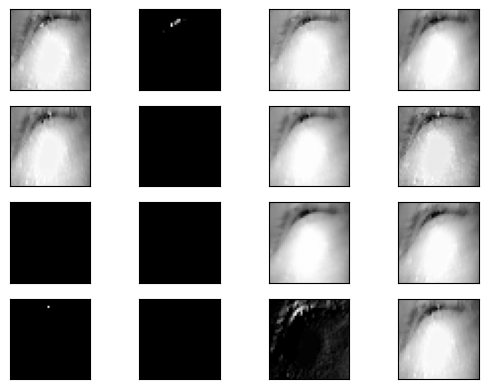

In [26]:
show_feat_map(model, X_test)

In [27]:
#Block2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (4, 4), activation='relu'))
model.add(MaxPooling2D(2, 2))

2/2 [==============================] - 0s 2ms/step


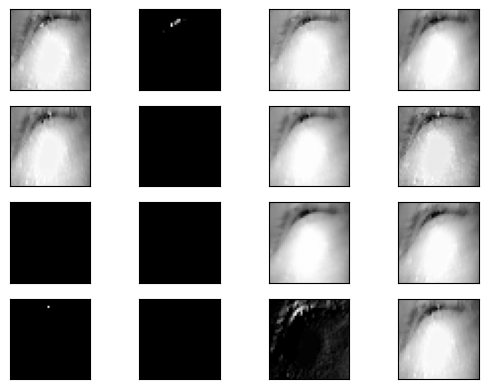

In [28]:
show_feat_map(model, X_test)

In [29]:
#Fully Connected Block
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='linear'))
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss=loss,
             metrics=['accuracy'])
model.summary(line_length=80)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d (Conv2D)                    (None, 168, 168, 24)            240         
                                                                                
 max_pooling2d (MaxPooling2D)       (None, 84, 84, 24)              0           
                                                                                
 conv2d_1 (Conv2D)                  (None, 82, 82, 32)              6944        
                                                                                
 max_pooling2d_1 (MaxPooling2D)     (None, 41, 41, 32)              0           
                                                                                
 conv2d_2 (Conv2D)                  (None, 39, 39, 64)              18496       
                                                                                
 max_poo

In [30]:
hist = model.fit(X_train, y_train,
                validation_data=(X_val, y_val),
                batch_size=30, epochs=15)

Epoch 1/15
10/10 [==============================] - 1s 50ms/step - loss: 0.0034 - accuracy: 0.4964 - val_loss: 0.0027 - val_accuracy: 0.4545
Epoch 2/15
10/10 [==============================] - 0s 14ms/step - loss: 0.0023 - accuracy: 0.4384 - val_loss: 0.0021 - val_accuracy: 0.3818
Epoch 3/15
10/10 [==============================] - 0s 16ms/step - loss: 0.0019 - accuracy: 0.4855 - val_loss: 0.0022 - val_accuracy: 0.3818
Epoch 4/15
10/10 [==============================] - 0s 14ms/step - loss: 0.0017 - accuracy: 0.4964 - val_loss: 0.0020 - val_accuracy: 0.5636
Epoch 5/15
10/10 [==============================] - 0s 16ms/step - loss: 0.0016 - accuracy: 0.5616 - val_loss: 0.0019 - val_accuracy: 0.4909
Epoch 6/15
10/10 [==============================] - 0s 14ms/step - loss: 0.0015 - accuracy: 0.5543 - val_loss: 0.0019 - val_accuracy: 0.5455
Epoch 7/15
10/10 [==============================] - 0s 15ms/step - loss: 0.0015 - accuracy: 0.5833 - val_loss: 0.0019 - val_accuracy: 0.5455
Epoch 8/15
10

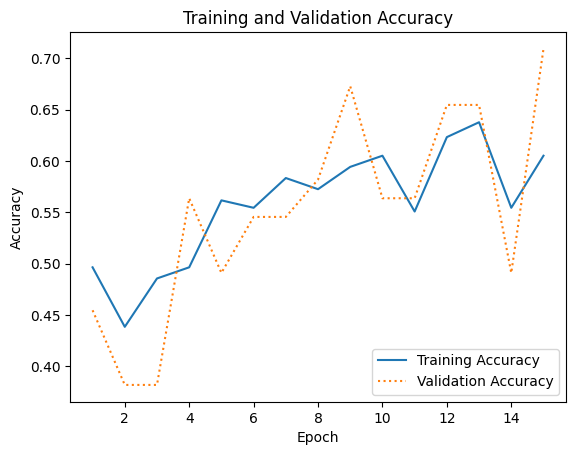

In [31]:
view_accuracy_metrics(hist, 'accuracy', 'val_accuracy')

In [32]:
bounds = model.predict(X_test)

2/2 [==============================] - 0s 20ms/step


In [33]:
view_image(X_test[3], int(bounds[3][0]*512),
            int(bounds[3][1]*512), int(bounds[3][2]*512), int(bounds[3][3]*512))

In [34]:
model.save(cwd + '\\my_models\\my_model1.h5')

<hr></hr>

### Copying VGG16 model

VGG16 is more commonly used as a classification model and has poor results for my application.
I am copying the basic VGG build from a schema found here https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918 

<hr></hr>

In [35]:
model = Sequential()

In [36]:
#Block 1
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(170, 170, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) 

2/2 [==============================] - 1s 148ms/step


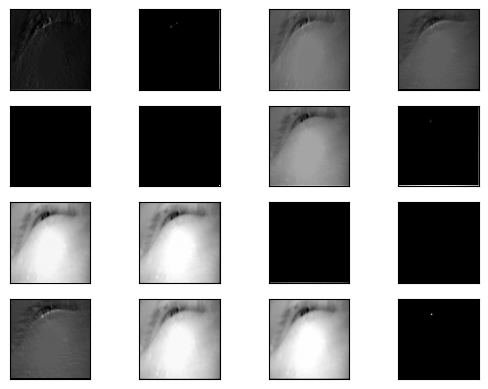

In [37]:
show_feat_map(model, X_test)

In [38]:
#Block 2
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

In [39]:

#Block 3
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

2/2 [==============================] - 0s 16ms/step


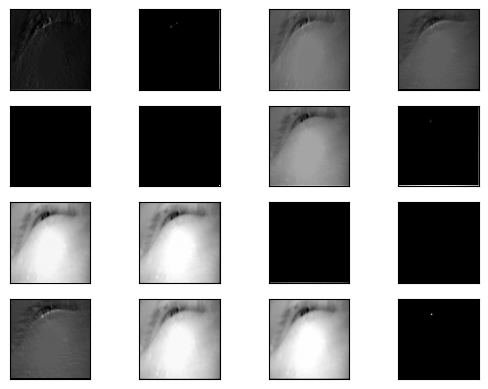

In [40]:
show_feat_map(model, X_test)

In [41]:
#Block 4
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

In [42]:
#Block 5
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

2/2 [==============================] - 0s 14ms/step


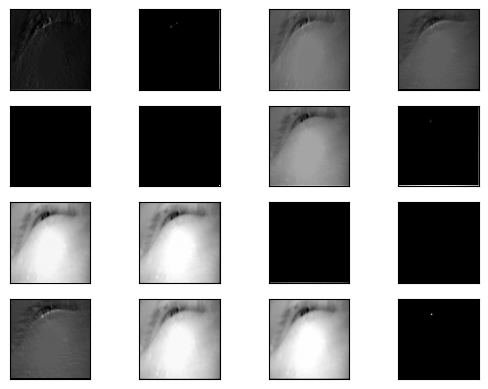

In [43]:
show_feat_map(model, X_test)

In [44]:
#Fully Connected Block
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='linear'))

In [45]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 170, 170, 64)      640       
                                                                 
 conv2d_5 (Conv2D)           (None, 170, 170, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 85, 85, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 85, 85, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 85, 85, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 42, 42, 128)      0         
 2D)                                                  

In [46]:
hist = model.fit(X_train, y_train,
                validation_data=(X_test, y_test),
                batch_size=10, epochs=12)

Epoch 1/12
28/28 [==============================] - 7s 149ms/step - loss: 0.1084 - mae: 0.1654 - val_loss: 0.0066 - val_mae: 0.0726
Epoch 2/12
28/28 [==============================] - 2s 54ms/step - loss: 0.0037 - mae: 0.0480 - val_loss: 0.0041 - val_mae: 0.0515
Epoch 3/12
28/28 [==============================] - 2s 54ms/step - loss: 0.0032 - mae: 0.0439 - val_loss: 0.0040 - val_mae: 0.0529
Epoch 4/12
28/28 [==============================] - 2s 55ms/step - loss: 0.0033 - mae: 0.0446 - val_loss: 0.0043 - val_mae: 0.0497
Epoch 5/12
28/28 [==============================] - 2s 54ms/step - loss: 0.0033 - mae: 0.0439 - val_loss: 0.0045 - val_mae: 0.0582
Epoch 6/12
28/28 [==============================] - 2s 54ms/step - loss: 0.0033 - mae: 0.0445 - val_loss: 0.0040 - val_mae: 0.0508
Epoch 7/12
28/28 [==============================] - 2s 54ms/step - loss: 0.0031 - mae: 0.0430 - val_loss: 0.0040 - val_mae: 0.0506
Epoch 8/12
28/28 [==============================] - 2s 54ms/step - loss: 0.0030 - 

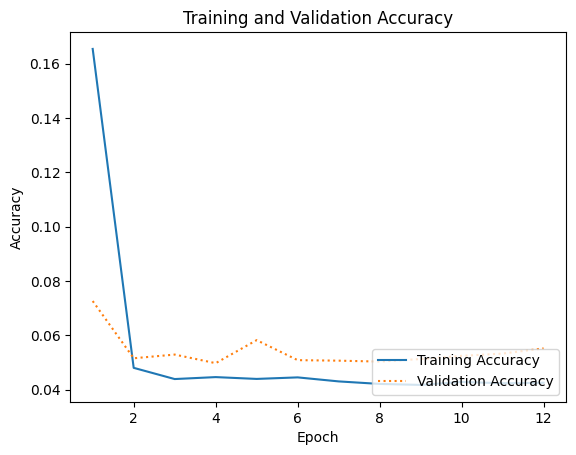

In [47]:
view_accuracy_metrics(hist, 'mae', 'val_mae')

In [48]:
bounds = model.predict(X_test)
view_image(X_test[1], int(bounds[1][0]*512),
            int(bounds[1][1]*512), int(bounds[1][2]*512), int(bounds[1][3]*512))

2/2 [==============================] - 2s 533ms/step


In [49]:
model.save(cwd + '\\my_models\\my_model2.h5')

### Combining VGG16 and Initial Model

In [50]:
#First model convlolutions
model = Sequential()
model.add(Conv2D(24, (3, 3), activation='relu', input_shape=(170, 170, 1)))
model.add(MaxPooling2D(2, 2)) 
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (4, 4), activation='relu'))
model.add(MaxPooling2D(2, 2)) 

#Block 3
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#Block 4
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#Block 5
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#Fully Connected Block
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='linear'))

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 168, 168, 24)      240       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 84, 84, 24)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 82, 82, 32)        6944      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 41, 41, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 39, 39, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 19, 19, 64)      

In [51]:
hist = model.fit(X_train, y_train,
                validation_data=(X_test, y_test),
                batch_size=10, epochs=32)

Epoch 1/32
28/28 [==============================] - 2s 33ms/step - loss: 0.1010 - mae: 0.1317 - val_loss: 0.0043 - val_mae: 0.0559
Epoch 2/32
28/28 [==============================] - 0s 15ms/step - loss: 0.0032 - mae: 0.0428 - val_loss: 0.0040 - val_mae: 0.0517
Epoch 3/32
28/28 [==============================] - 0s 15ms/step - loss: 0.0031 - mae: 0.0424 - val_loss: 0.0040 - val_mae: 0.0513
Epoch 4/32
28/28 [==============================] - 0s 14ms/step - loss: 0.0030 - mae: 0.0416 - val_loss: 0.0040 - val_mae: 0.0521
Epoch 5/32
28/28 [==============================] - 0s 14ms/step - loss: 0.0030 - mae: 0.0415 - val_loss: 0.0040 - val_mae: 0.0508
Epoch 6/32
28/28 [==============================] - 0s 14ms/step - loss: 0.0031 - mae: 0.0425 - val_loss: 0.0041 - val_mae: 0.0497
Epoch 7/32
28/28 [==============================] - 0s 15ms/step - loss: 0.0031 - mae: 0.0426 - val_loss: 0.0044 - val_mae: 0.0495
Epoch 8/32
28/28 [==============================] - 0s 15ms/step - loss: 0.0031 - m

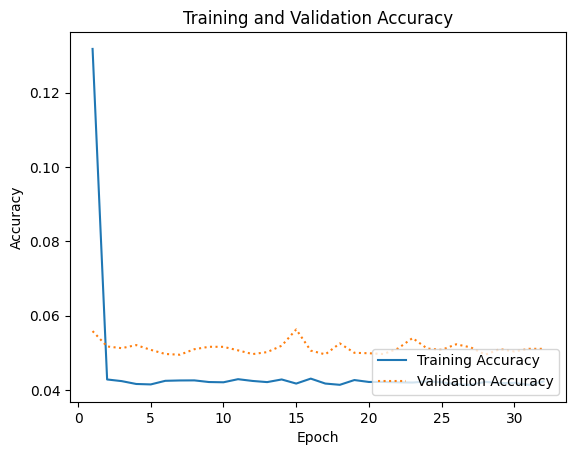

In [52]:
view_accuracy_metrics(hist, 'mae', 'val_mae')

In [53]:
model.save(cwd + '\\my_models\\my_model3.h5')

### Focusing on more abstract feature maps

In [54]:
loss = Huber(delta=1.0)

model = Sequential()

#Block1
model.add(Conv2D(24, (3, 3), activation='relu', input_shape=(170, 170, 1)))
model.add(MaxPooling2D(2, 2)) 
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))


In [55]:
#Block2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))


In [56]:
#Block3
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

2/2 [==============================] - 0s 34ms/step


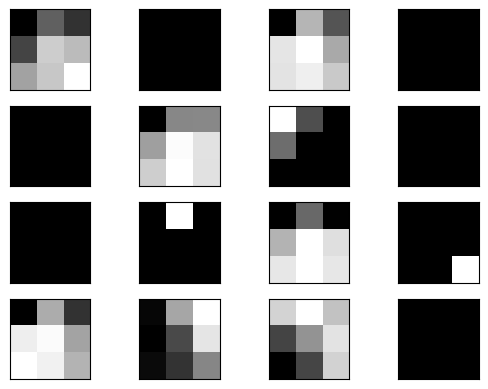

In [57]:
show_feat_map(model, X_test)

In [58]:
#Fully Connected Block
model.add(Flatten())
model.add(Dense(170, activation='relu'))
model.add(Dense(4, activation='linear'))
model.compile(optimizer='adam', loss=loss,
             metrics=['accuracy'])
model.summary(line_length=80)


Model: "sequential_3"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_28 (Conv2D)                 (None, 168, 168, 24)            240         
                                                                                
 max_pooling2d_16 (MaxPooling2D)    (None, 84, 84, 24)              0           
                                                                                
 conv2d_29 (Conv2D)                 (None, 82, 82, 32)              6944        
                                                                                
 max_pooling2d_17 (MaxPooling2D)    (None, 41, 41, 32)              0           
                                                                                
 conv2d_30 (Conv2D)                 (None, 39, 39, 64)              18496       
                                                                                
 max_p

In [59]:
hist = model.fit(X_train, y_train,
                validation_data=(X_val, y_val),
                batch_size=100, epochs=100)

Epoch 1/100
3/3 [==============================] - 2s 424ms/step - loss: 0.0165 - accuracy: 0.3297 - val_loss: 0.0063 - val_accuracy: 0.3636
Epoch 2/100
3/3 [==============================] - 0s 48ms/step - loss: 0.0051 - accuracy: 0.4710 - val_loss: 0.0026 - val_accuracy: 0.4545
Epoch 3/100
3/3 [==============================] - 0s 48ms/step - loss: 0.0021 - accuracy: 0.4094 - val_loss: 0.0024 - val_accuracy: 0.3636
Epoch 4/100
3/3 [==============================] - 0s 47ms/step - loss: 0.0019 - accuracy: 0.4819 - val_loss: 0.0021 - val_accuracy: 0.3636
Epoch 5/100
3/3 [==============================] - 0s 47ms/step - loss: 0.0017 - accuracy: 0.4819 - val_loss: 0.0019 - val_accuracy: 0.7455
Epoch 6/100
3/3 [==============================] - 0s 48ms/step - loss: 0.0015 - accuracy: 0.5254 - val_loss: 0.0016 - val_accuracy: 0.6909
Epoch 7/100
3/3 [==============================] - 0s 48ms/step - loss: 0.0012 - accuracy: 0.6739 - val_loss: 0.0012 - val_accuracy: 0.6545
Epoch 8/100
3/3 [==

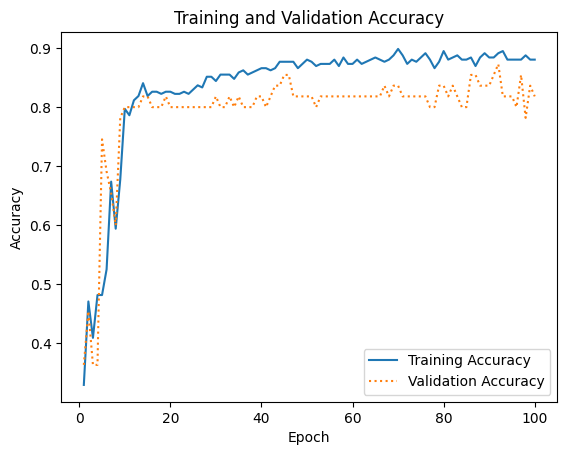

In [60]:
view_accuracy_metrics(hist, 'accuracy', 'val_accuracy')

In [61]:
bounds = model.predict(X_test)
view_image(X_test[1], int(bounds[1][0]*512),
            int(bounds[1][1]*512), int(bounds[1][2]*512), int(bounds[1][3]*512))

2/2 [==============================] - 0s 0s/step


In [62]:
model.save(cwd + '\\my_models\\my_model4.h5')

### Attempting to tune the previous design

In [63]:
from tensorflow.keras.layers import LeakyReLU

loss = Huber(delta=1.0)

model = Sequential()

#Block1
model.add(Conv2D(24, (3, 3), activation=LeakyReLU(alpha=0.1), input_shape=(170, 170, 1)))
model.add(Conv2D(24, (3, 3), activation=LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(2, 2)) 

#Block2
model.add(Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.1)))
model.add(Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(2, 2))


In [64]:
#Block2
model.add(Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.1)))
model.add(Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(2, 2))

#Block3
model.add(Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.1)))
model.add(Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(2, 2))


2/2 [==============================] - 0s 17ms/step


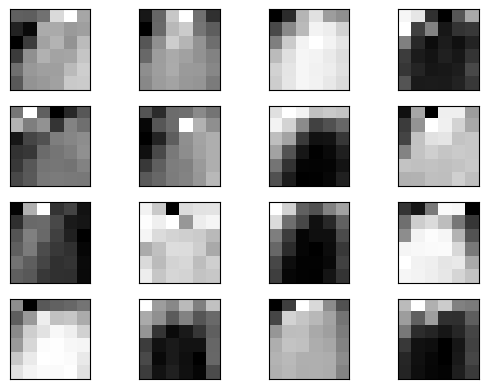

In [65]:
show_feat_map(model, X_test)

In [66]:
#Fully Connected Block
model.add(Flatten())
model.add(Dense(170, activation=LeakyReLU(alpha=0.1)))
model.add(Dense(170, activation=LeakyReLU(alpha=0.1)))
model.add(Dense(4, activation='linear'))

model.compile(optimizer='adam', loss=loss,
             metrics=['accuracy'])
model.summary(line_length=80)


Model: "sequential_4"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_33 (Conv2D)                 (None, 168, 168, 24)            240         
                                                                                
 conv2d_34 (Conv2D)                 (None, 166, 166, 24)            5208        
                                                                                
 max_pooling2d_21 (MaxPooling2D)    (None, 83, 83, 24)              0           
                                                                                
 conv2d_35 (Conv2D)                 (None, 81, 81, 32)              6944        
                                                                                
 conv2d_36 (Conv2D)                 (None, 79, 79, 32)              9248        
                                                                                
 max_p

In [67]:
hist = model.fit(X_train, y_train,
                validation_data=(X_val, y_val),
                batch_size=100, epochs=100)

Epoch 1/100
3/3 [==============================] - 3s 549ms/step - loss: 0.0190 - accuracy: 0.2754 - val_loss: 0.0024 - val_accuracy: 0.3636
Epoch 2/100
3/3 [==============================] - 0s 103ms/step - loss: 0.0048 - accuracy: 0.4783 - val_loss: 0.0067 - val_accuracy: 0.3636
Epoch 3/100
3/3 [==============================] - 0s 95ms/step - loss: 0.0057 - accuracy: 0.4275 - val_loss: 0.0027 - val_accuracy: 0.4545
Epoch 4/100
3/3 [==============================] - 0s 105ms/step - loss: 0.0025 - accuracy: 0.3007 - val_loss: 0.0025 - val_accuracy: 0.1636
Epoch 5/100
3/3 [==============================] - 0s 95ms/step - loss: 0.0021 - accuracy: 0.3478 - val_loss: 0.0022 - val_accuracy: 0.3636
Epoch 6/100
3/3 [==============================] - 0s 101ms/step - loss: 0.0019 - accuracy: 0.4529 - val_loss: 0.0021 - val_accuracy: 0.4545
Epoch 7/100
3/3 [==============================] - 0s 97ms/step - loss: 0.0016 - accuracy: 0.3913 - val_loss: 0.0020 - val_accuracy: 0.3636
Epoch 8/100
3/3 

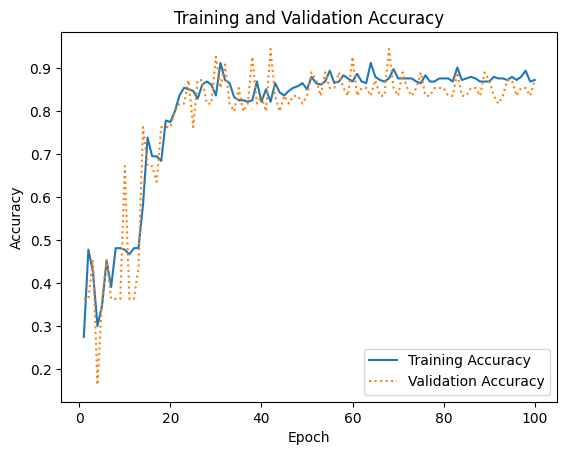

In [68]:
view_accuracy_metrics(hist, 'accuracy', 'val_accuracy')

In [69]:
bounds = model.predict(X_test)
view_image(X_test[1], int(bounds[1][0]*512),
            int(bounds[1][1]*512), int(bounds[1][2]*512), int(bounds[1][3]*512))

2/2 [==============================] - 0s 1ms/step


In [70]:
model.save(cwd + '\\my_models\\my_model5.h5')

Clearing memory that python and tensoflow have loaded onto ram and vram.

In [71]:
# Clearing gpu and python memory
import gc

tf.keras.backend.clear_session()
gc.collect()

43474